In [1]:
import pandas as pd
import os

In [2]:
from bioinfokit import visuz, analys

# PCA plot

In [3]:
counts_dir = "/data6/deepro/collaboration/payal_cornell/data/RNA-seq/results/count"
libraries = ["dox0", "dox1", "dox1E210"]
count_filename = "counts.tsv"

def read_counts_file(counts_dir, lib, filename):
    df = pd.read_csv(os.path.join(counts_dir, lib, filename), sep="\t", skipfooter=5, index_col=0)
    return df.drop(columns="gene_name")

def get_meta_counts(counts_dir, libraries, count_filenames):
    df = pd.concat([read_counts_file(counts_dir, lib, count_filenames) for lib in libraries], axis=1)
    return df



In [4]:
meta_df = get_meta_counts(counts_dir, libraries, count_filename)

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [5]:
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
import seaborn as sns

In [12]:
def get_pca_components(meta_df):
    meta_df_norm = (meta_df-meta_df.mean())/meta_df.std()
    pca = PCA(n_components=2)

    components = pca.fit_transform(meta_df_norm.T)

    pca_df = pd.DataFrame({
        "lib_info": meta_df_norm.columns,
        "pca_comp1": components[:, 0],
        "pca_comp2": components[:, 1],
        "library": [c.split("_")[0] for c in meta_df_norm.columns],
    })

    return pca_df


def get_pca_plots(meta_df):

    pca_df = get_pca_components(meta_df) 
    fig, ax = plt.subplots(1, 1, figsize=(8,4), sharex=True, sharey=True)
    sns.scatterplot(
        data=pca_df, 
        x="pca_comp1", 
        y="pca_comp2", 
        hue="library", 
        style="library", 
        legend=True, 
        ax=ax, 
        s=150,
        alpha=1.,
        linewidth=1.05,
        edgecolor="k",
        # linestyle='--',
        )
    ax.set_title("PCA plot")
    ax.legend(loc="lower center",, markerscale=2)
    return fig

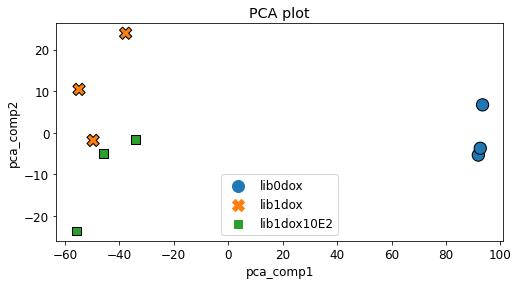

In [13]:
f = get_pca_plots(meta_df)

In [3]:
de_results_dir = "/data6/deepro/collaboration/payal_cornell/data/RNA-seq/results/de"
treatment="dox1"
control="dox0"
deseq_filebase="de_results.csv"
gid2n_filebase="geneid2name.csv"

In [44]:
def read_deseq_results(results_dir, treatment, control, deseq_filebase, gid2n_filebase):
    deres_filename = os.path.join(results_dir, "vs".join([treatment, control]), deseq_filebase)
    gid2n_filename = os.path.join(results_dir, "vs".join([treatment, control]), gid2n_filebase)
    deres_df = pd.read_csv(deres_filename)
    gid2n_df = pd.read_csv(gid2n_filename, index_col=0)
    df = pd.concat((deres_df, gid2n_df), axis=1)
    # drop rows with na values
    df = df.dropna()
    # convert all 0 padj values to half of the min padj value thats greater than 0
    df.loc[df.padj==0, "padj"] = min(df.loc[df.padj>0].padj)/10
    return df

# Volcano plot

In [45]:
de_df = read_deseq_results(de_results_dir, treatment, control, deseq_filebase, gid2n_filebase)


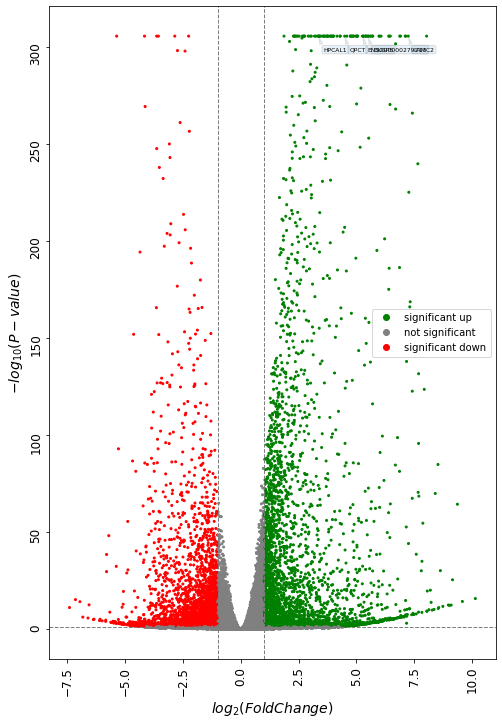

In [49]:
visuz.gene_exp.volcano(
        df=de_df,
        lfc='log2FoldChange', 
        pv='padj',
        geneid="gene_name",
        genenames=tuple(de_df.sort_values("padj", ascending=True).gene_name)[:5],
        gstyle=2,
        gfont=20,
        show=True,
        dotsize=4,
        dim=(8, 12),
        sign_line=True,
        plotlegend=True,
        axtickfontsize=12,
        axlabelfontsize=14,
        figname=f'{treatment}vs{control}.pdf',
        )

In [36]:
de_df.sort_values("padj")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
ENSG00000115828.17,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,0.0
ENSG00000138166.6,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,0.0
ENSG00000115756.13,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,0.0
ENSG00000279713.1,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,0.0
ENSG00000058085.15,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,1.989561e-305,0.0
...,...,...,...,...,...,...,...
ENSG00000174891.14,3.582244e+02,-1.427324e-04,1.350025e-01,-1.057257e-03,9.991564e-01,9.993294e-01,RSRC1
ENSG00000249628.3,1.178699e+00,1.646371e-03,2.125820e+00,7.744643e-04,9.993821e-01,9.995118e-01,LINC00942
ENSG00000013561.18,1.413048e+03,-2.860897e-05,7.743988e-02,-3.694345e-04,9.997052e-01,9.997917e-01,RNF14
ENSG00000135077.10,1.477656e+00,-4.288173e-04,1.952773e+00,-2.195940e-04,9.998248e-01,9.998680e-01,HAVCR2
